# Discretization of the MIT dataset house 2

In [1]:
%matplotlib inline

# Hacky solution to set the working path to the parent folder (upis)
# It is supposed to execute only once
import os, sys
if os.getcwd().find('notebooks') >= 0:
    os.chdir(os.getcwd() + '/..')
    sys.path.append(os.getcwd() + '/sourcecode')

import matplotlib.pyplot as plt

from DataProcessor import DataProcessor
from Parser import DatasetPath
from Headers import SensorProcessedDataHeaders

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 19
BIGGER_SIZE = 29

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The dataset comes as the input of 3 separated files, but there is already implemented a script to process them and keep only the most important information for the learning algorithms. Let's start by first reading the dataset and process it to a structure with the sensor id, the activity label and two timestamps indicating the start and end.

In [3]:
path = DatasetPath.MIT2

dp = DataProcessor(path=path)
data = dp.process_sensors()

data.head()

,SENSOR_ID,ACTIVITY,START,END
0,115,Preparing dinner,2003-05-01 16:14:24,2003-05-01 16:16:16
1,115,Preparing dinner,2003-05-01 16:17:10,2003-05-01 16:17:21
2,79,Preparing dinner,2003-05-01 16:17:45,2003-05-01 16:18:18
3,73,Preparing dinner,2003-05-01 16:17:50,2003-05-01 16:17:54
4,73,Preparing dinner,2003-05-01 16:18:09,2003-05-01 16:18:15


As we can see, it is difficult to indicate how long the sensor has been active only from the two timestamps. Let's create a new column which indicates this.

Why do we do this?

Because classification algorithms do not handle well timestamps and it is more efficient to explicite state the data we want to consider. (Also, one of the other limitations is that they do not have the capability to deduce that the day repeats every 24h.) We could build a custom algorithm, or we can process the data to discretise the timestamps by the period they start and how long did they last. We will choose the last option.

In [4]:
data['duration'] = data[SensorProcessedDataHeaders.END] - data[SensorProcessedDataHeaders.START]

data.head()

,SENSOR_ID,ACTIVITY,START,END,duration
0,115,Preparing dinner,2003-05-01 16:14:24,2003-05-01 16:16:16,00:01:52
1,115,Preparing dinner,2003-05-01 16:17:10,2003-05-01 16:17:21,00:00:11
2,79,Preparing dinner,2003-05-01 16:17:45,2003-05-01 16:18:18,00:00:33
3,73,Preparing dinner,2003-05-01 16:17:50,2003-05-01 16:17:54,00:00:04
4,73,Preparing dinner,2003-05-01 16:18:09,2003-05-01 16:18:15,00:00:06


Now that we have the duration, let's sort them, because we want to see what is their distribution and sorting them helps making better decisions.

In [5]:
duration = data['duration'].copy()

duration.sort_values(inplace=True)

duration.head()

1546   00:00:01
1559   00:00:01
911    00:00:01
1558   00:00:01
916    00:00:01
Name: duration, dtype: timedelta64[ns]

As we can see, we have repeated values. Let's convert them into seconds and count the frequency of each unique value.

In [6]:
duration_seconds = duration.apply(lambda x: x.total_seconds())

print('These are the 10 most frequent durations:')
print(duration_seconds.value_counts().head(10))

print('\nThese are the 10 least frequent durations:')
print(duration_seconds.value_counts().tail(10))

print('\nAnd in total we have', duration_seconds.value_counts().shape[0], 'different values')

These are the 10 most frequent durations:
1.0     211
3.0     109
4.0     107
5.0     100
2.0      93
7.0      87
6.0      65
8.0      46
9.0      44
11.0     39
Name: duration, dtype: int64

These are the 10 least frequent durations:
501.0      1
202.0      1
206.0      1
16111.0    1
210.0      1
218.0      1
348.0      1
16246.0    1
436.0      1
49749.0    1
Name: duration, dtype: int64

And in total we have 554 different values


In [7]:
def frequency_bigger_than(count):
    return duration_seconds.value_counts()[duration_seconds.value_counts() > count]

print('Also, there are', frequency_bigger_than(0).shape[0] - frequency_bigger_than(1).shape[0], 'values which only occur one time')

Also, there are 382 values which only occur one time


As we can see we have 382 sensor activities whose exact time span occurs only one time. Can we discard them? Well, no. Given that the precision is to the second the same activity may not last always the same. So, let's cluster them to allow better decisions (we do this because we have too many single values which would deteriorate the perform of, for instance, a Random Forest).

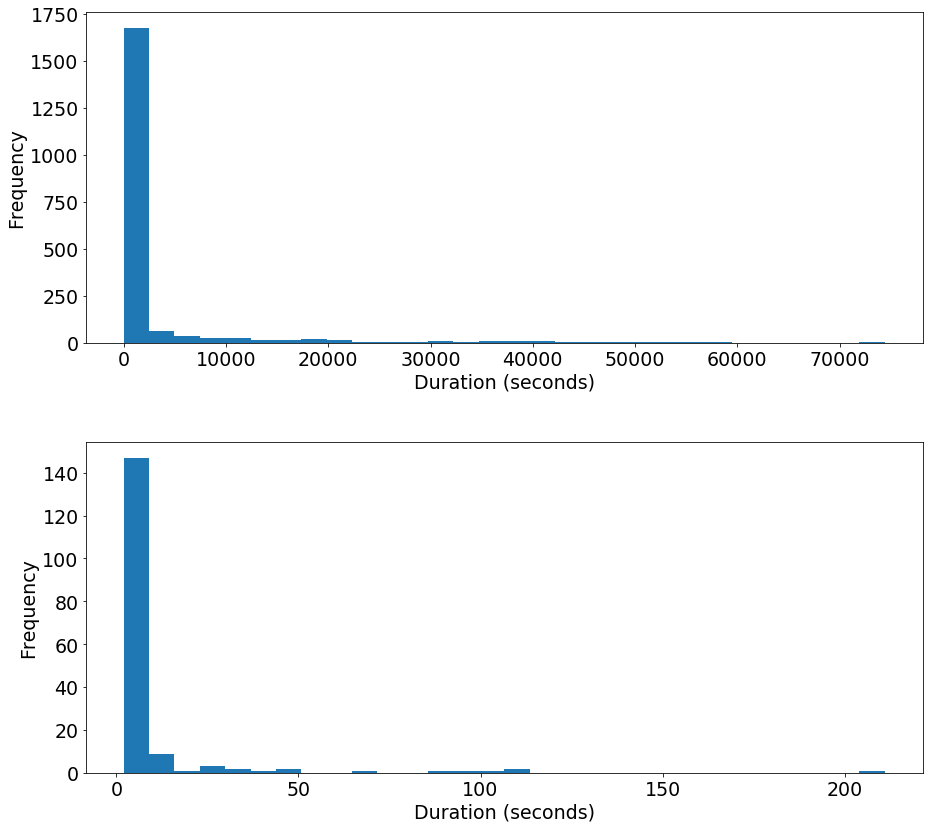

In [8]:
n_bins = 30

plt.figure(figsize=(15,14))

plt.subplots_adjust(hspace=0.3)

plt.subplot(2,1,1)
#plt.title(f'This is what the data looks like if we have {n_bins} bins')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.hist(duration_seconds, bins=n_bins)

plt.subplot(2,1,2)
#plt.title('And if we ignore the values that happen only once, then it looks like this (notice that both axis changed)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.hist(frequency_bigger_than(1), bins=n_bins)
plt.ioff()

As we can see this distribution is very similar to a [pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution). In fact, you can easily see it with a lognormal scale.

In [9]:
percentile = 0.75

print(percentile, 'of the total values last, at most,', duration_seconds.quantile(percentile), 'seconds')

0.75 of the total values last, at most, 233.50000000000003 seconds


So, 25% of the values last more than 233 seconds. From now on, let's not consider more these values for a while and let's focus on the other 75%.

In [10]:
long_duration = duration_seconds[duration_seconds >= 233]

Now that we stored on another variable all the durations longer or equal to 233 seconds, let's remove them from the variable we are analysing.

In [11]:
duration_seconds = duration_seconds[duration_seconds < 233]

print('Total of', duration_seconds.shape[0], 'rows')

Total of 1471 rows


Let's plot it again

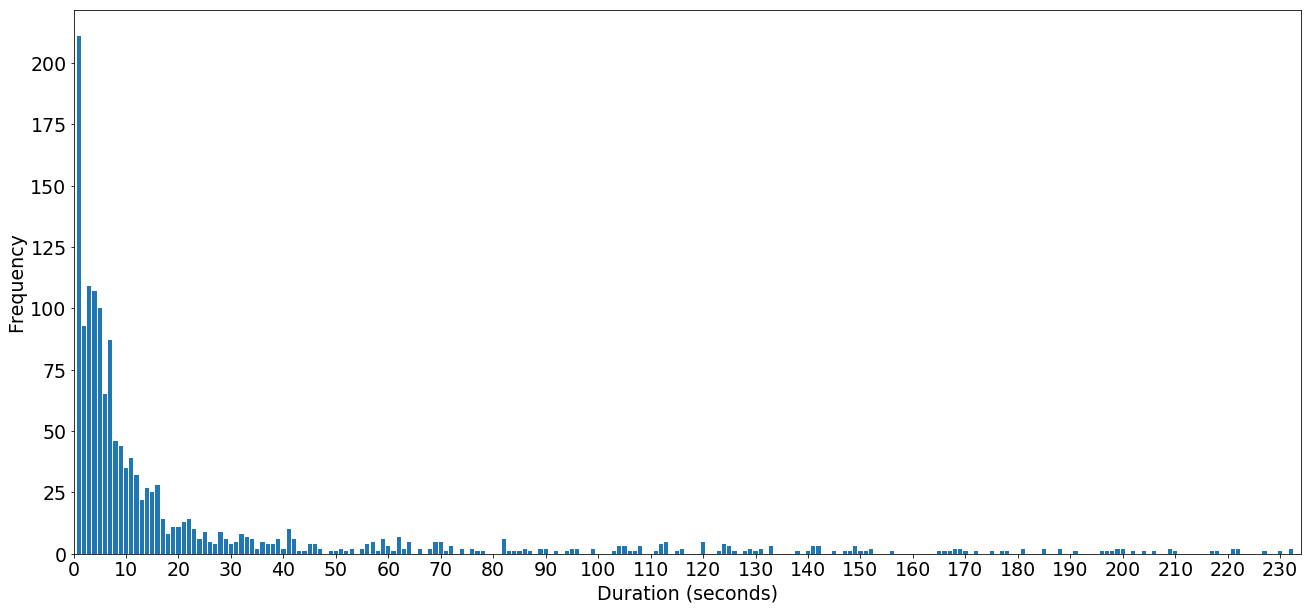

In [12]:
plt.figure(figsize=(22,10))

# plt.title('This is what the data looks like if we have ' + str(n_bins) + ' bins')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.xlim(0,234)
plt.xticks([second for second in range(0, 234, 10)])
plt.hist(duration_seconds, bins=[i-0.4 for i in range(234)], width=0.8)

plt.ioff()

In [13]:
percentile = 0.75

print(percentile, 'of the total values last, at most,', duration_seconds.quantile(percentile), 'seconds')

0.75 of the total values last, at most, 19.5 seconds


Now, 25% of the values last longer than 19 seconds. Let's also separate these.

In [14]:
medium_duration = duration_seconds[duration_seconds >= 19]

duration_seconds = duration_seconds[duration_seconds < 19]

print('Total of', duration_seconds.shape[0], 'rows')

Total of 1092 rows


And again we plot

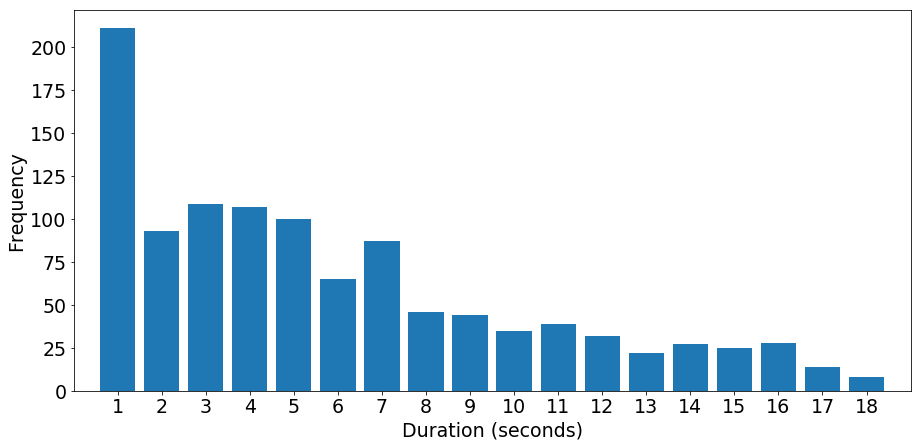

In [15]:
plt.figure(figsize=(15,7))

# plt.title('This is what the data looks like if we have' + str(n_bins))
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.xlim(0,19)
plt.xticks([second for second in range(1, 19)])
plt.hist(duration_seconds, bins=[i-0.4 for i in range(20)], width=0.8)

plt.ioff()

In a more numerical perspective:

In [16]:
duration_seconds.value_counts()

1.0     211
3.0     109
4.0     107
5.0     100
2.0      93
7.0      87
6.0      65
8.0      46
9.0      44
11.0     39
10.0     35
12.0     32
16.0     28
14.0     27
15.0     25
13.0     22
17.0     14
18.0      8
Name: duration, dtype: int64

In [17]:
percentile = 0.5

print(percentile, 'of the total values last, at most,', duration_seconds.quantile(percentile), 'seconds')

0.5 of the total values last, at most, 5.0 seconds


What can we deduce? Fast activities are very common. 50% of them last 5 seconds. Due to the small range of values (1 to 18 seconds), let's separate these into two groups of almost equal size.

In [18]:
short_duration = duration_seconds[duration_seconds > 5]

ultra_short_duration = duration_seconds[duration_seconds <= 5]

So, now we divided into 4 clusters: ultra short, short, medium and long. However, this split is not statistically significant without analysing the variables with more detail while taking into account the context. Anyway, the process chosen for now is trial and error, and this analysis should be enough.

In [19]:
print('There are', ultra_short_duration.shape[0], 'ultra short values (vales <= 5 seconds)')
print('There are', short_duration.shape[0], 'short values (5 < values < 19)')
print('There are', medium_duration.shape[0], 'medium values (19 <= values < 233)')
print('There are', long_duration.shape[0], 'long values (>= 233 seconds)')

total_values = ultra_short_duration.shape[0] + short_duration.shape[0] + medium_duration.shape[0] + long_duration.shape[0]

print('\nIn total, there are', total_values, 'values which is the same number as the ' +
      'number of rows of the original processed data (', duration.shape[0], ')')

There are 620 ultra short values (vales <= 5 seconds)
There are 472 short values (5 < values < 19)
There are 379 medium values (19 <= values < 233)
There are 491 long values (>= 233 seconds)

In total, there are 1962 values which is the same number as the number of rows of the original processed data ( 1962 )


### Let's close this chapter where we analyse the duration of the events, and now focus on the starting period.

Let's start by seeing when the dataset starts and when it ends.

In [20]:
data[SensorProcessedDataHeaders.START].min()

Timestamp('2003-04-19 03:09:01')

In [21]:
data[SensorProcessedDataHeaders.END].max()

Timestamp('2003-05-04 22:16:02')

In [22]:
time_delta = data[SensorProcessedDataHeaders.END].max() - data[SensorProcessedDataHeaders.START].min()
time_delta

Timedelta('15 days 19:07:01')

We now know that the dataset was collected in 2003 during March and April and it lasted 2 weeks (15 days). But what about their occurrence during the day? Let's just keep the hour

In [23]:
hours = data[SensorProcessedDataHeaders.START].apply(lambda x: x.hour)

hours.value_counts()

9     271
5     211
11    172
7     145
16    136
6     131
17    125
10    122
8     109
15     90
12     80
19     64
18     63
14     58
13     54
20     52
4      34
21     25
22      6
2       5
1       4
0       3
3       1
23      1
Name: START, dtype: int64

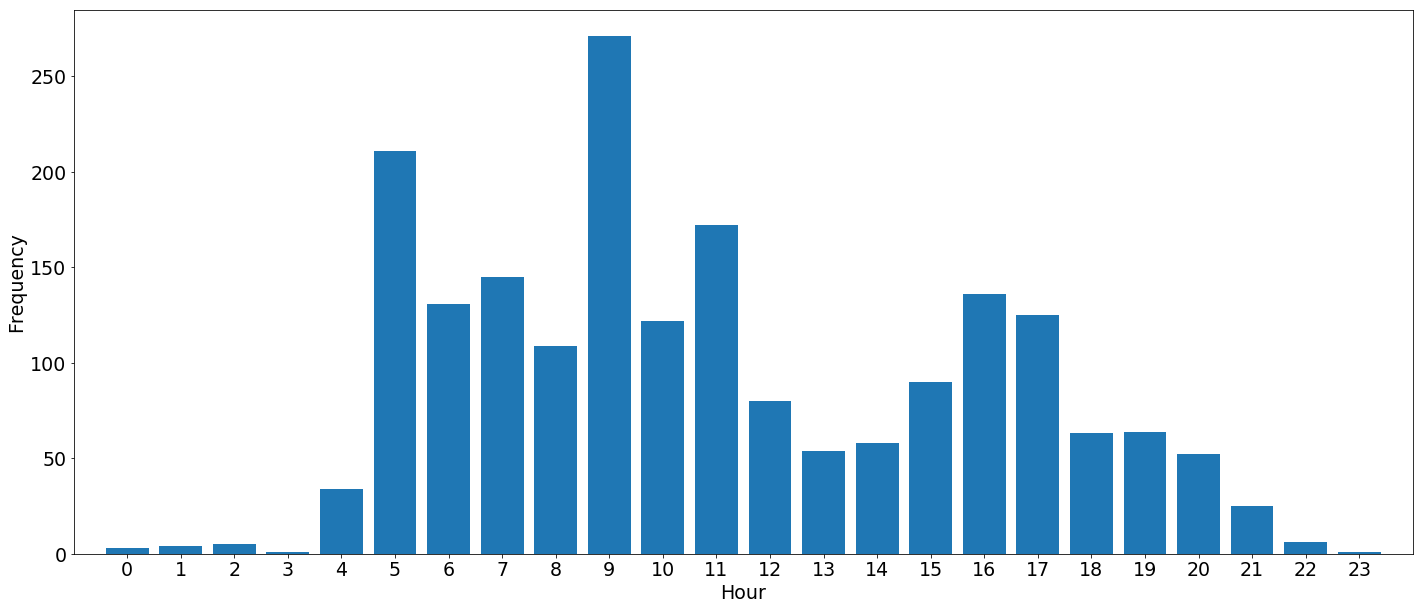

In [24]:
plt.figure(figsize=(24,10))

# plt.title('This is what the data looks like if we have ' + str(n_bins))
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xlim(-1,24)
plt.xticks([hour for hour in range(0,24)])
plt.hist(hours, bins=[i-0.4 for i in range(25)], width=0.8)

plt.ioff()

Let's start by first considering the usual periods of the day

In [25]:
morning = hours[hours[hours >= 7] & hours[hours <= 12]]
afternoon = hours[hours[hours > 12] & hours[hours < 18]]
evening = hours[hours >= 18] # 0 is midnight
night = hours[hours < 7]

print('Number of values for morning:', morning.shape[0])
print('Number of values for afternoon:', afternoon.shape[0])
print('Number of values for evening:', evening.shape[0])
print('Number of values for night:', night.shape[0])

Number of values for morning: 588
Number of values for afternoon: 269
Number of values for evening: 211
Number of values for night: 389


We can see that there is less activity during the night than during the other periods. This possibly indicates that the user is sleeping. For now, we will avoid further study given that this split should be enough for now to test some algorithms. We will adjust the level of focus according to the results we get.

### Let's close this chapter where we analyse the periods of the day, and now focus on the day the activities occur.

To be faster, let's infer that the habitant has routines and they are periodic. So, each 7 days the data mostly repeats itself. Given that, up to this point, we discarded the timestamps of start and end of the activities to periods of the day and their duration, we must also add an extra variable that takes into consideration when they occur. So, let's do it.

In [26]:
days = data[SensorProcessedDataHeaders.START].apply(lambda x: x.weekday_name)
days.unique()

array(['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday'], dtype=object)

In [27]:
days.value_counts()

Sunday       448
Saturday     422
Thursday     341
Wednesday    270
Friday       185
Monday       166
Tuesday      130
Name: START, dtype: int64

### We can now close this chapter and implement this analysis.